In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier,BaggingRegressor,BaggingClassifier, \
AdaBoostRegressor,AdaBoostClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from pyearth import Earth
import itertools as it
import time as time
import xgboost as xgb
import re 

In [51]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

In [52]:
y_train

,quality
0,5
1,6
2,5
3,6
4,6
...,...
2933,6
2934,6
2935,6
2936,6


In [53]:
#Defining the object to build a regression tree
model = DecisionTreeClassifier(random_state=1) 

#Fitting the regression tree to the data
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [54]:
# Maximum number of leaves
model.get_n_leaves()

841

In [55]:
# Maximum depth
model.get_depth()

23

In [56]:
len(X_train.columns)

11

In [57]:
# coarse grid search
param_grid = {    
    'max_depth': range(2,24,2),
    'max_leaf_nodes': range(2,841,50),
    'max_features': range(1, 12,2),
    'min_samples_leaf': range(1,10,2)
}


#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=5)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'accuracy', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 5610 candidates, totalling 28050 fits
Train accuracy : 0.972
Test accuracy : 0.559
Best Accuracy Through Grid Search : 0.548
Best params for recall
{'max_depth': 20, 'max_features': 11, 'max_leaf_nodes': 702, 'min_samples_leaf': 1}


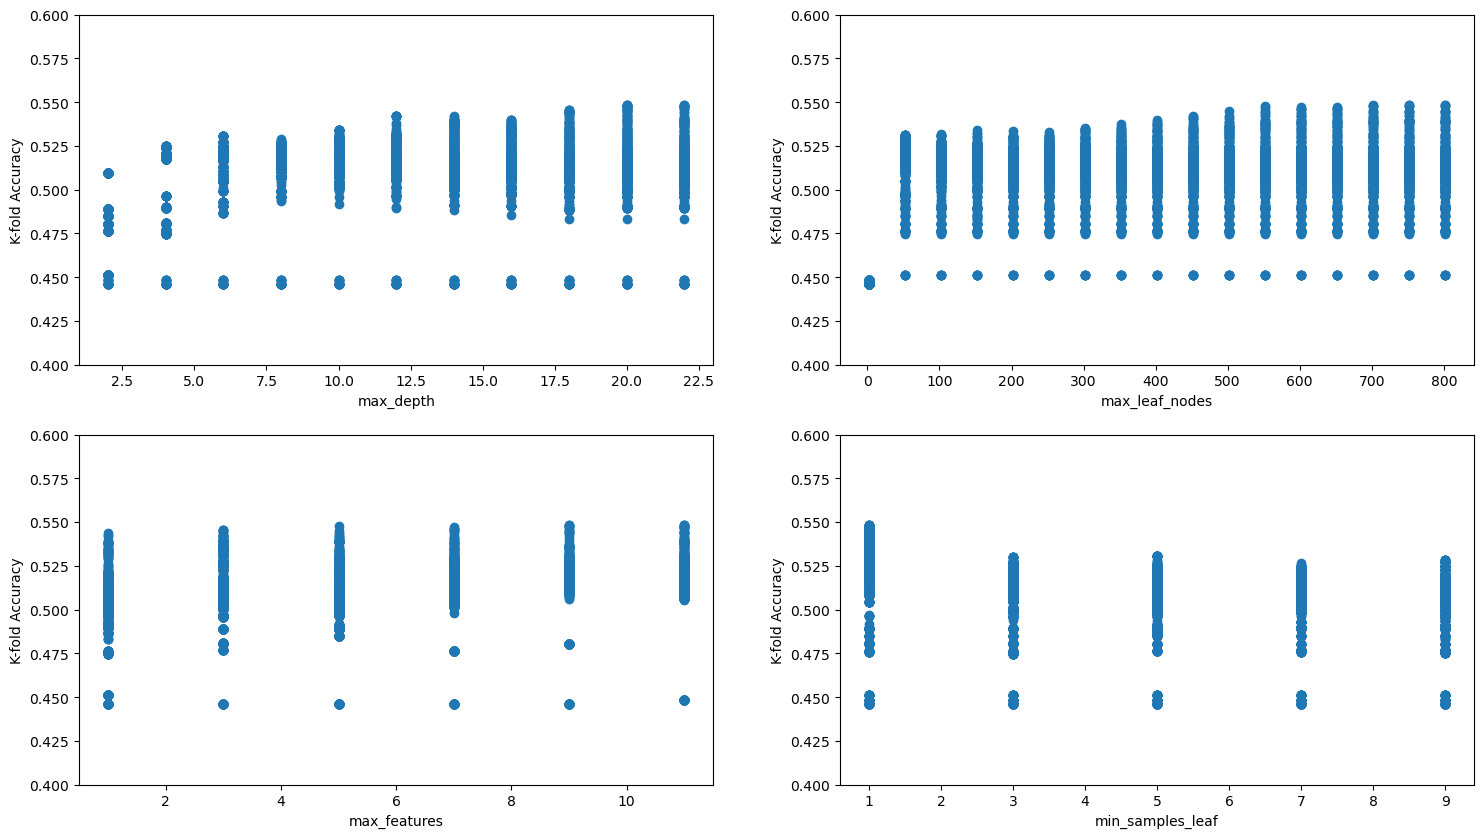

In [58]:
cv_results = pd.DataFrame(grid_search.cv_results_)
fig, axes = plt.subplots(2,2,figsize=(18,10))
plt.subplots_adjust(wspace=0.2)
axes[0,0].plot(cv_results.param_max_depth, cv_results.mean_test_accuracy, 'o')
axes[0,0].set_ylim([0.4, 0.6])
axes[0,0].set_xlabel('max_depth')
axes[0,0].set_ylabel('K-fold Accuracy')
axes[0,1].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_accuracy, 'o')
axes[0,1].set_ylim([0.4, 0.6])
axes[0,1].set_xlabel('max_leaf_nodes')
axes[0,1].set_ylabel('K-fold Accuracy')
axes[1,0].plot(cv_results.param_max_features, cv_results.mean_test_accuracy, 'o')
axes[1,0].set_ylim([0.4, 0.6])
axes[1,0].set_xlabel('max_features')
axes[1,0].set_ylabel('K-fold Accuracy')
axes[1,1].plot(cv_results.param_min_samples_leaf, cv_results.mean_test_accuracy, 'o')
axes[1,1].set_ylim([0.4, 0.6])
axes[1,1].set_xlabel('min_samples_leaf')
axes[1,1].set_ylabel('K-fold Accuracy');

In [60]:
# finer grid search
param_grid = {    
    'max_depth': range(12,24),
    'max_leaf_nodes': range(400,842,10),
    'max_features': range(1,12)
}


#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=5)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'accuracy', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 5940 candidates, totalling 29700 fits
Train accuracy : 0.919
Test accuracy : 0.548
Best Accuracy Through Grid Search : 0.554
Best params for recall
{'max_depth': 15, 'max_features': 8, 'max_leaf_nodes': 610}


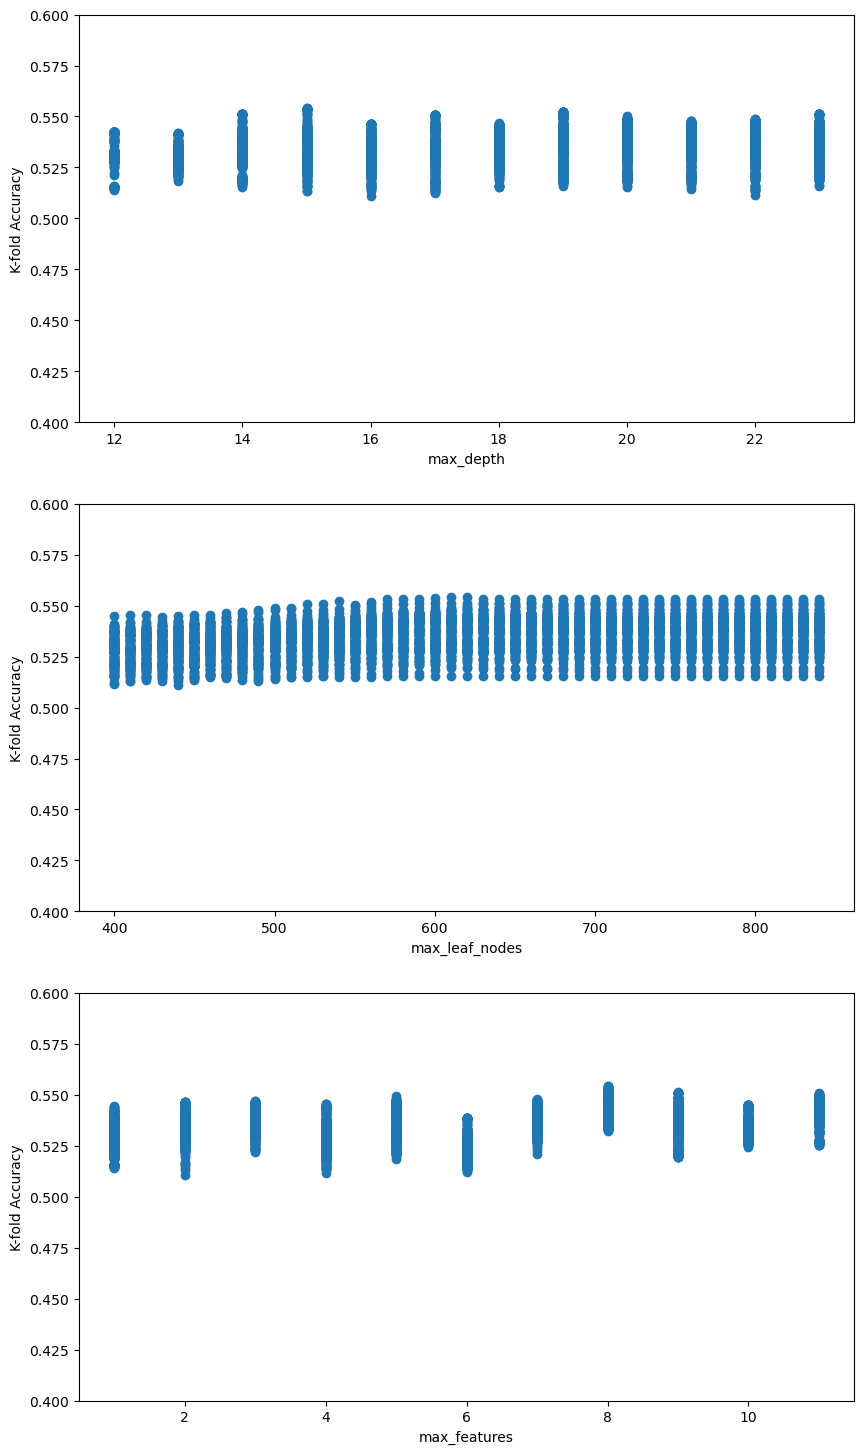

In [62]:
cv_results = pd.DataFrame(grid_search.cv_results_)
fig, axes = plt.subplots(3,1,figsize=(10,18))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, cv_results.mean_test_accuracy, 'o')
axes[0].set_ylim([0.4, 0.6])
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('K-fold Accuracy')
axes[1].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_accuracy, 'o')
axes[1].set_ylim([0.4, 0.6])
axes[1].set_xlabel('max_leaf_nodes')
axes[1].set_ylabel('K-fold Accuracy')
axes[2].plot(cv_results.param_max_features, cv_results.mean_test_accuracy, 'o')
axes[2].set_ylim([0.4, 0.6])
axes[2].set_xlabel('max_features')
axes[2].set_ylabel('K-fold Accuracy');

In [66]:
# finer grid search
param_grid = {    
    'max_depth': range(14,24),
    'max_leaf_nodes': range(600,842,25),
    'max_features': range(1,12)
}


#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=5)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'accuracy', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)

Fitting 5 folds for each of 1100 candidates, totalling 5500 fits
Train accuracy : 0.917
Test accuracy : 0.548
Best Accuracy Through Grid Search : 0.554
Best params for recall
{'max_depth': 15, 'max_features': 8, 'max_leaf_nodes': 600}


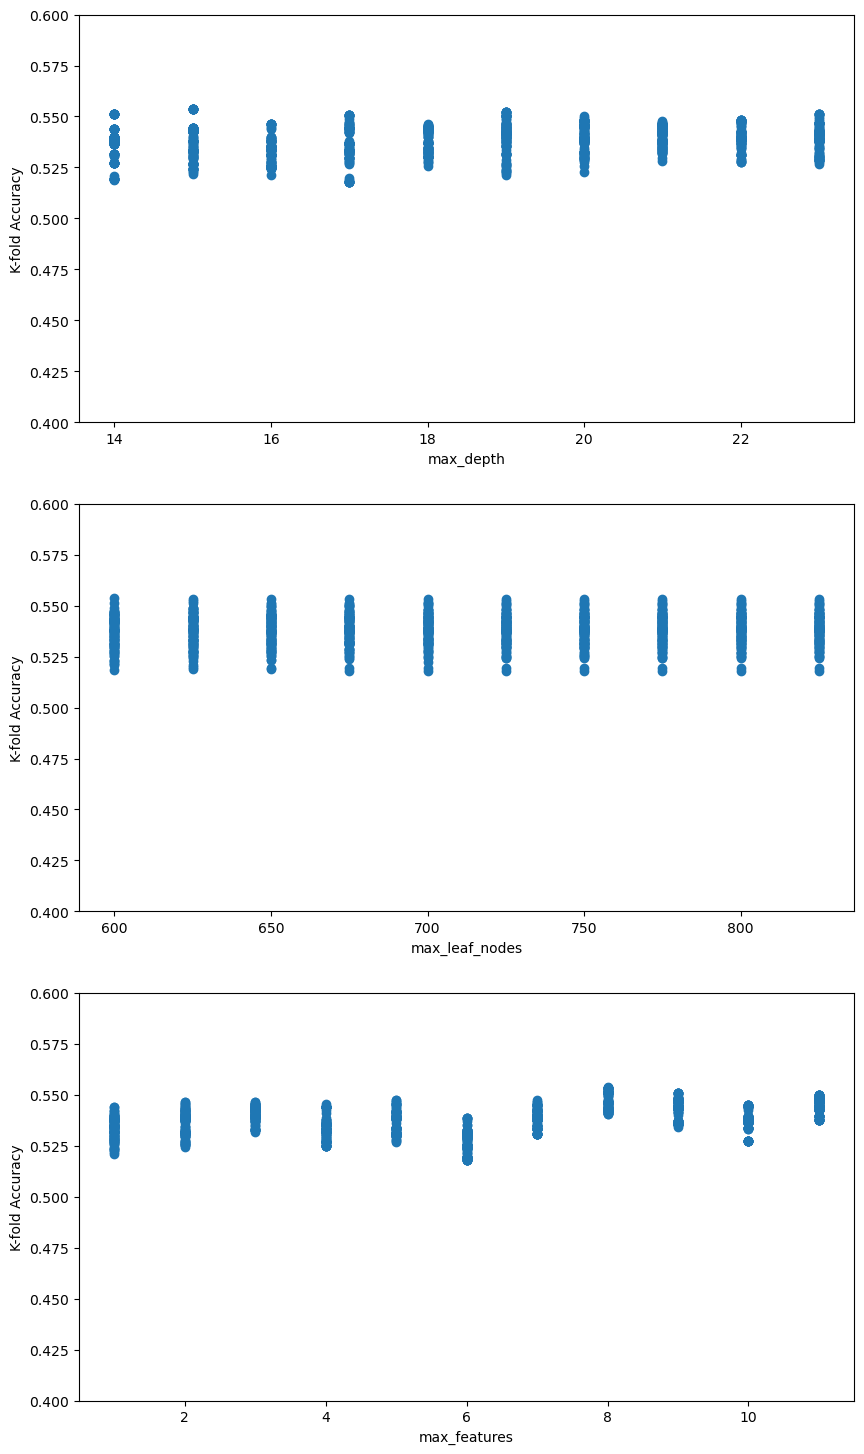

In [67]:
cv_results = pd.DataFrame(grid_search.cv_results_)
fig, axes = plt.subplots(3,1,figsize=(10,18))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, cv_results.mean_test_accuracy, 'o')
axes[0].set_ylim([0.4, 0.6])
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('K-fold Accuracy')
axes[1].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_accuracy, 'o')
axes[1].set_ylim([0.4, 0.6])
axes[1].set_xlabel('max_leaf_nodes')
axes[1].set_ylabel('K-fold Accuracy')
axes[2].plot(cv_results.param_max_features, cv_results.mean_test_accuracy, 'o')
axes[2].set_ylim([0.4, 0.6])
axes[2].set_xlabel('max_features')
axes[2].set_ylabel('K-fold Accuracy');

In [ ]:
# finer grid search
param_grid = {    
    'max_depth': range(12,24),
    'max_leaf_nodes': range(550,700),
    'max_features': range(6,12)
}


#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=5)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['f1_weighted','accuracy'], refit= 'accuracy', cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%grid_search.best_score_)

print('Best params for recall')
print(grid_search.best_params_)